##### 导入必要的包

In [1]:
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import re
from   sklearn.model_selection import train_test_split
from   matplotlib import pyplot as plt

##### 读取数据

In [2]:
''' 读取数据 '''
data = pd.read_csv("./Tweets.csv")
''' 选出两列用于构造数据集 '''
data = data[['airline_sentiment','text']]
''' 查看数据 '''
# data

' 查看数据 '

In [3]:
''' 查看评论中的情绪分类类型数量 '''
# data.airline_sentiment.unique()

' 查看评论中的情绪分类类型数量 '

In [4]:
''' 查看数据集的详情 '''
''' 判断是否有缺失值 '''
# data.info()

' 判断是否有缺失值 '

In [5]:
''' 判断是否有重复值 '''
# data.duplicated().sum() #如果两个值是重复的则设置为True~1 反之则为False~0

' 判断是否有重复值 '

In [6]:
''' 就地删除重复值 '''
data.drop_duplicates(inplace=True)

In [7]:
''' 查看不同种类情绪的数量 '''
# data.airline_sentiment.value_counts()

' 查看不同种类情绪的数量 '

In [8]:
''' 将评论结果数据数值化 '''
label = pd.factorize(data.airline_sentiment)[0]

In [9]:
''' 处理评论数据 '''
tokren = re.compile('[A-Za-z]+')
def pre_text(text):
    text = tokren.findall(text)
    text = [w.lower() for w in text] # 将文本转化为小写
    return text
x = data.text.apply(pre_text) #在数据集上对 text属性应用pre_text函数
'''  输出最后的数据集 '''
# x

'  输出最后的数据集 '

In [10]:
''' 创建词表 '''

# 将所有的单词添加到set中
word_set = set()
for t in x:
    for word in t:
        word_set.add(word)

In [11]:
''' 查看一共需要考虑多少个单词  '''
# len(word_set)

' 查看一共需要考虑多少个单词  '

In [12]:
''' 设置词表一共需要为多少个单词进行编码 '''
max_word = len(word_set) + 1  # +1表示unknown

In [13]:
word_list = list(word_set)

In [14]:
'''  查看某一个单词在列表中的index序号 '''
# word_list.index('you')

'  查看某一个单词在列表中的index序号 '

In [15]:
word_to_index = dict((w,word_list.index(w)+1) for w in word_list) #0号位置存放unknown

In [16]:
''' 查看所创建的词表 '''
# word_to_index 

' 查看所创建的词表 '

In [17]:
x = x.apply(lambda t:[word_to_index.get(w,0) for w in t]) #将x中的文字编码为数值形式 t指的就是数据集x中的每一句话
# x

In [18]:
''' 找出评论的最大长度 '''
maxlen = max(len(t) for t in x)
# maxlen

In [19]:
''' 简单起见，将评论长度全部填充为长度34 '''
pad_x = [t + (maxlen-len(t))*[0] for t in x]

In [20]:
pad_x = np.array(pad_x)

In [21]:
''' 填充过后的数据形状 '''
# pad_x.shape  

' 填充过后的数据形状 '

In [22]:
# label.shape

In [23]:
''' 切分数据集为测试&训练两部分 '''
x_train,x_test,y_train,y_test = train_test_split(pad_x,label)

In [24]:
# x_train.shape

In [25]:
# x_test.shape

In [26]:
# y_train.shape

In [27]:
# y_test.shape

In [28]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self,text,label):
        self.text_array = text
        self.label_array= label
    
    def __getitem__(self,index):
        text = torch.LongTensor(self.text_array[index])
        label= self.label_array[index]
        return text,label
        
    def __len__(self):
        return len(self.text_array)

In [29]:
train_ds = MyDataSet(x_train,y_train)
test_ds  = MyDataSet(x_test,y_test)

In [30]:
BATCH_SIZE = 32

In [31]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl  = torch.utils.data.DataLoader(test_ds ,batch_size=BATCH_SIZE,shuffle=True)

##### 创建模型 并测试(version01 全连接模型)

In [32]:
embedding_dim = 100

In [33]:
class Net01(nn.Module):
    def __init__(self):
        super(Net01,self).__init__()
        self.em = nn.Embedding(max_word,embedding_dim)#将max_word个单词编码到embedding_dim维向量中  batch*maxlen*100
        self.fc1= nn.Linear(maxlen*100,1024)
        self.fc2= nn.Linear(1024,3)
    
    def forward(self,x):
        x = self.em(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [34]:
model     = Net01()
model     = model.to("cuda")
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
def fit(epoch, model, trainloader, testloader):
    correct      = 0
    total        = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        x, y   = x.to("cuda"), y.to("cuda")
        y_pred = model(x)
        loss   = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred        = torch.argmax(y_pred, dim=1)
            correct      += (y_pred == y).sum().item()
            total        += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc  = correct / total
        
        
    test_correct      = 0
    test_total        = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y   = x.to("cuda"), y.to("cuda")
            y_pred = model(x)
            loss   = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct      += (y_pred == y).sum().item()
            test_total        += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc  = test_correct / test_total
    
        
    print('epoch: ', epoch,'loss： ', round(epoch_loss, 3),'accuracy:', round(epoch_acc, 3),'test_loss： ', round(epoch_test_loss, 3),'test_accuracy:', round(epoch_test_acc, 3))
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [36]:
epochs     = 10
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [37]:
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,model,train_dl,test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.025 accuracy: 0.671 test_loss：  0.024 test_accuracy: 0.682
epoch:  1 loss：  0.019 accuracy: 0.748 test_loss：  0.023 test_accuracy: 0.709
epoch:  2 loss：  0.013 accuracy: 0.825 test_loss：  0.024 test_accuracy: 0.729
epoch:  3 loss：  0.009 accuracy: 0.89 test_loss：  0.029 test_accuracy: 0.729
epoch:  4 loss：  0.006 accuracy: 0.934 test_loss：  0.032 test_accuracy: 0.723
epoch:  5 loss：  0.004 accuracy: 0.956 test_loss：  0.037 test_accuracy: 0.714
epoch:  6 loss：  0.003 accuracy: 0.968 test_loss：  0.042 test_accuracy: 0.717
epoch:  7 loss：  0.002 accuracy: 0.979 test_loss：  0.044 test_accuracy: 0.726
epoch:  8 loss：  0.002 accuracy: 0.985 test_loss：  0.048 test_accuracy: 0.715
epoch:  9 loss：  0.001 accuracy: 0.989 test_loss：  0.056 test_accuracy: 0.706


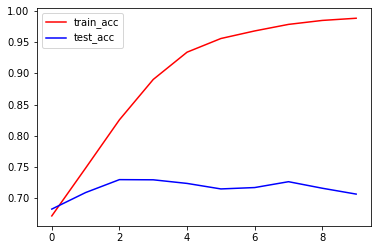

In [38]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc,  c='b', label='test_acc')
plt.legend()

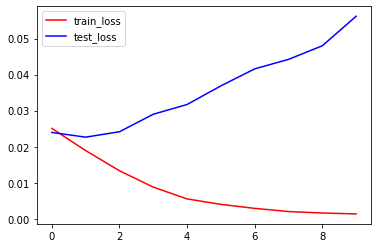

In [39]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss,  c='b', label='test_loss')
plt.legend()

##### 创建模型 并测试(version02 LSTM模型)

In [40]:
embedding_dim = 100
hidden_size   = 200

In [41]:
class Net02(nn.Module):
    def __init__(self,max_word,embedding_dim):
        super(Net02,self).__init__()
        self.em   = nn.Embedding(max_word,embedding_dim)#将max_word个单词编码到embedding_dim维向量中  batch*maxlen*100
        self.lstm = nn.LSTM(embedding_dim,hidden_size,batch_first=True)
        self.fc1  = nn.Linear(hidden_size,256)
        self.fc2  = nn.Linear(256,3)
    
    def forward(self,x):
        x   = self.em(x)
        x,_ = self.lstm(x)
        x   = self.fc1(x[:,-1,:])
        x   = F.relu(x)
        x   = self.fc2(x)
        return x

In [42]:
model     = Net02(max_word,embedding_dim)
model     = model.to("cuda")
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
epochs     = 10
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [44]:
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,model,train_dl,test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.026 accuracy: 0.649 test_loss：  0.023 test_accuracy: 0.669
epoch:  1 loss：  0.021 accuracy: 0.712 test_loss：  0.021 test_accuracy: 0.73
epoch:  2 loss：  0.017 accuracy: 0.779 test_loss：  0.02 test_accuracy: 0.754
epoch:  3 loss：  0.014 accuracy: 0.831 test_loss：  0.02 test_accuracy: 0.748
epoch:  4 loss：  0.011 accuracy: 0.878 test_loss：  0.02 test_accuracy: 0.762
epoch:  5 loss：  0.008 accuracy: 0.918 test_loss：  0.022 test_accuracy: 0.763
epoch:  6 loss：  0.006 accuracy: 0.944 test_loss：  0.025 test_accuracy: 0.755
epoch:  7 loss：  0.004 accuracy: 0.96 test_loss：  0.027 test_accuracy: 0.746
epoch:  8 loss：  0.003 accuracy: 0.974 test_loss：  0.032 test_accuracy: 0.751
epoch:  9 loss：  0.002 accuracy: 0.981 test_loss：  0.037 test_accuracy: 0.748


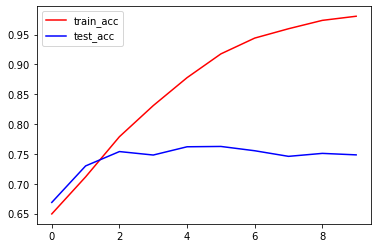

In [45]:
plt.plot(range(epochs), train_acc, c='r', label='train_acc')
plt.plot(range(epochs), test_acc,  c='b', label='test_acc')
plt.legend()

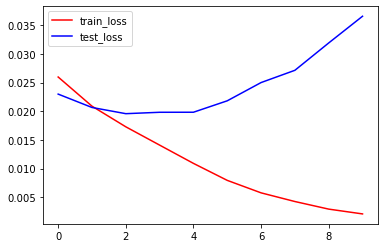

In [46]:
plt.plot(range(epochs), train_loss, c='r', label='train_loss')
plt.plot(range(epochs), test_loss,  c='b', label='test_loss')
plt.legend()